In [1]:
import torchvision
import torch
import torch.nn as nn
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
%cd /content/drive/MyDrive/ERA/ERA_S10

/content/drive/MyDrive/ERA/ERA_S10


In [4]:
!ls

data  model  utils


Import Packages

In [7]:
from model.custom_resnet import CustomResnet
from model.train import Train
from model.test import Test
from utils.utils import Utils
from data.data import CIFAR10data

In [8]:
CIFAR10_data = CIFAR10data()
utils = Utils()
train = Train()
test = Test()
customresnet = CustomResnet()

In [9]:
data = CIFAR10_data.get_data()
mean, std = CIFAR10_data.get_dataset_mean_std(data)
train_transforms, test_transforms = CIFAR10_data.get_transform(mean, std)
train_data, test_data = CIFAR10_data.get_transform_data(train_transforms, test_transforms)
train_dataloader, test_dataloader = CIFAR10_data.get_dataloader(train_data, test_data)

100%|██████████| 170498071/170498071 [00:10<00:00, 15627158.76it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
INFO: Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]
Files already downloaded and verified
Files already downloaded and verified


In [10]:
device = utils.get_device()
device

'cuda'

In [11]:
sample_batch = next(iter(train_dataloader))[0]
sample_img_grid = torchvision.utils.make_grid(sample_batch)
sample_batch.shape[1:]

torch.Size([3, 32, 32])

In [12]:
images, labels = next(iter(train_dataloader))

In [13]:
images[0].shape, labels[0]

(torch.Size([3, 32, 32]), tensor(5))

In [14]:
data.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Get Ramdom Inages from the dataset

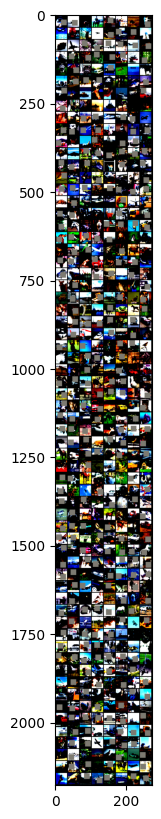

In [15]:
utils.show_random_images(data_loader=train_dataloader)

Show Image Grid

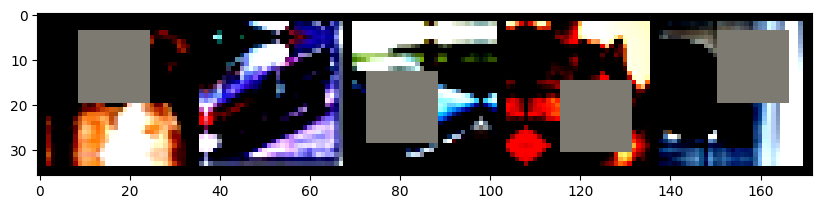

In [16]:
utils.show_img_grid(images[:5])

Model Summary

In [17]:
net = customresnet.to(device)
utils.show_model_summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
         ResBlock-14          [-1, 128,

Initialise Optimiser and Criterion

In [18]:
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.002, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

Find the Steepest LR

  0%|          | 0/600 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.19E-02


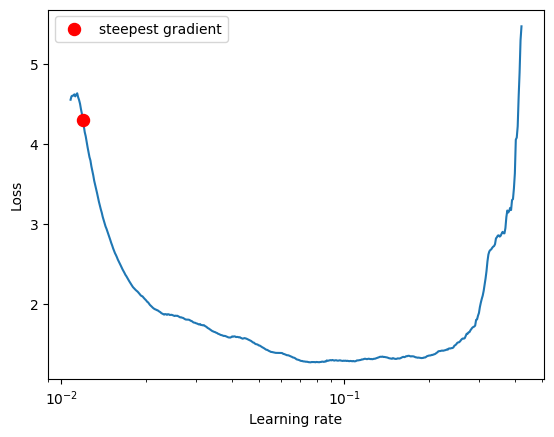

In [19]:
utils.find_lr(
    model=net,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    trainloader=train_dataloader,
    numiter=600,
    endlr=1.0,
    startlr=1e-2,
)

Initialise One Cycle Policy Scheduler

In [20]:
epochs = 24
maxlr = 1.19E-03
scheduler = utils.one_cycle_lr(
    optimizer=optimizer, maxlr=maxlr, steps=len(train_dataloader), epochs=epochs
)

Train Model

In [21]:
results = dict(trainloss=[], trainacc=[], testloss=[], testacc=[], epoch=[], lr=[])

for epoch in range(1, epochs + 1):
    print(f"Epoch: {epoch}")

    batch_trainloss, batch_trainacc, lrs = train.train(
        model=net,
        device=device,
        optimizer=optimizer,
        criterion=criterion,
        train_loader=train_dataloader,
        scheduler=scheduler,
    )

    results["trainloss"].append(np.mean(batch_trainloss))
    results["trainacc"].append(np.mean(batch_trainacc))

    testloss, testacc = test.test(
        model=net, device=device, criterion=criterion, test_loader=test_dataloader
    )
    results["testloss"].append(testloss)
    results["testacc"].append(testacc)

    results["lr"].extend(lrs)
    results["epoch"].append(epoch)

Epoch: 1


Loss=1.30 Accuracy=37.45: 100%|██████████| 98/98 [00:36<00:00,  2.70it/s]



Test set: Average loss: 1.2825, Accuracy: 5361/10000 (53.61%)

Epoch: 2


Loss=1.12 Accuracy=57.45: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 1.0118, Accuracy: 6508/10000 (65.08%)

Epoch: 3


Loss=0.89 Accuracy=65.65: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]



Test set: Average loss: 0.8181, Accuracy: 7158/10000 (71.58%)

Epoch: 4


Loss=0.70 Accuracy=71.13: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.7595, Accuracy: 7354/10000 (73.54%)

Epoch: 5


Loss=0.81 Accuracy=74.60: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.6428, Accuracy: 7802/10000 (78.02%)

Epoch: 6


Loss=0.57 Accuracy=77.31: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]



Test set: Average loss: 0.6169, Accuracy: 8030/10000 (80.30%)

Epoch: 7


Loss=0.55 Accuracy=80.36: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]



Test set: Average loss: 0.5835, Accuracy: 7998/10000 (79.98%)

Epoch: 8


Loss=0.47 Accuracy=81.93: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.4507, Accuracy: 8467/10000 (84.67%)

Epoch: 9


Loss=0.48 Accuracy=83.56: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]



Test set: Average loss: 0.4615, Accuracy: 8479/10000 (84.79%)

Epoch: 10


Loss=0.46 Accuracy=84.42: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]



Test set: Average loss: 0.4180, Accuracy: 8561/10000 (85.61%)

Epoch: 11


Loss=0.38 Accuracy=85.77: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.4400, Accuracy: 8550/10000 (85.50%)

Epoch: 12


Loss=0.34 Accuracy=86.83: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]



Test set: Average loss: 0.3936, Accuracy: 8715/10000 (87.15%)

Epoch: 13


Loss=0.34 Accuracy=87.48: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]



Test set: Average loss: 0.3435, Accuracy: 8859/10000 (88.59%)

Epoch: 14


Loss=0.34 Accuracy=88.27: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.3367, Accuracy: 8872/10000 (88.72%)

Epoch: 15


Loss=0.30 Accuracy=89.14: 100%|██████████| 98/98 [00:33<00:00,  2.94it/s]



Test set: Average loss: 0.3040, Accuracy: 8984/10000 (89.84%)

Epoch: 16


Loss=0.26 Accuracy=89.87: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]



Test set: Average loss: 0.3129, Accuracy: 8955/10000 (89.55%)

Epoch: 17


Loss=0.30 Accuracy=90.44: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]



Test set: Average loss: 0.3374, Accuracy: 8907/10000 (89.07%)

Epoch: 18


Loss=0.26 Accuracy=91.10: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]



Test set: Average loss: 0.2785, Accuracy: 9066/10000 (90.66%)

Epoch: 19


Loss=0.25 Accuracy=91.72: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]



Test set: Average loss: 0.2747, Accuracy: 9077/10000 (90.77%)

Epoch: 20


Loss=0.21 Accuracy=92.48: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]



Test set: Average loss: 0.2798, Accuracy: 9085/10000 (90.85%)

Epoch: 21


Loss=0.18 Accuracy=93.00: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]



Test set: Average loss: 0.2633, Accuracy: 9134/10000 (91.34%)

Epoch: 22


Loss=0.19 Accuracy=93.55: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]



Test set: Average loss: 0.2437, Accuracy: 9181/10000 (91.81%)

Epoch: 23


Loss=0.13 Accuracy=94.15: 100%|██████████| 98/98 [00:31<00:00,  3.06it/s]



Test set: Average loss: 0.2349, Accuracy: 9209/10000 (92.09%)

Epoch: 24


Loss=0.21 Accuracy=94.46: 100%|██████████| 98/98 [00:33<00:00,  2.91it/s]



Test set: Average loss: 0.2353, Accuracy: 9216/10000 (92.16%)



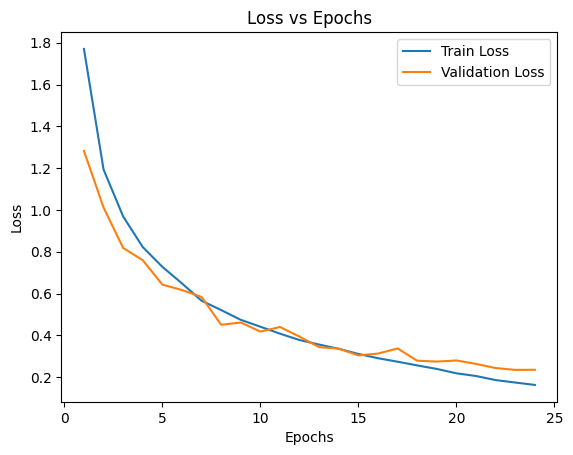

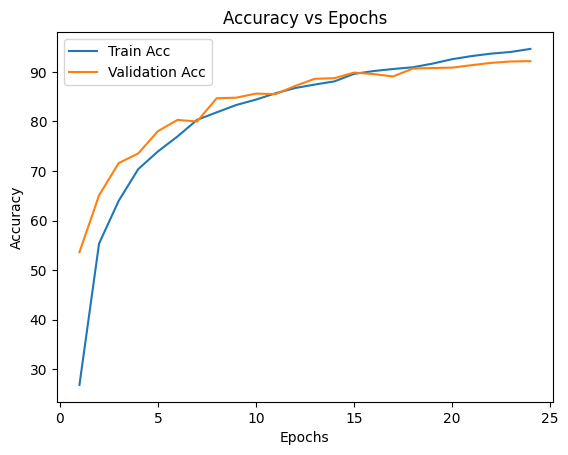

In [23]:
utils.training_plots(results)

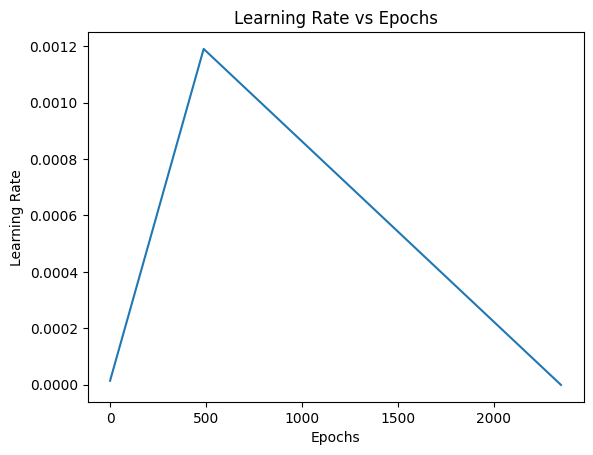

In [24]:
utils.lr_plots(results, length=len(train_dataloader) * epochs)